<a href="https://colab.research.google.com/github/yiyichanmyae/time_series/blob/main/4_rnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0
Epoch 1/100
49/49 [==============================] - 4s 22ms/step - loss: 0.1758 - mae: 0.1758
Epoch 2/100
49/49 [==============================] - 2s 37ms/step - loss: 0.1491 - mae: 0.1491
Epoch 3/100
49/49 [==============================] - 1s 22ms/step - loss: 0.1459 - mae: 0.1459
Epoch 4/100
49/49 [==============================] - 1s 21ms/step - loss: 0.1466 - mae: 0.1466
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.1456 - mae: 0.1456
Epoch 6/100
49/49 [==============================] - 1s 22ms/step - loss: 0.1453 - mae: 0.1453
Epoch 7/100
49/49 [==============================] - 1s 22ms/step - loss: 0.1451 - mae: 0.1451
Epoch 8/100
49/49 [==============================] - 1s 23ms/step - loss: 0.1443 - mae: 0.1443
Epoch 9/100
49/49 [==============================] - 2s 34ms/step - loss: 0.1450 - mae: 0.1450
Epoch 10/100
49/49 [==============================] - 1s 23ms/step 

array([59.953636, 60.043003, 60.40982 , 60.16294 , 60.14738 , 60.449116,
       59.752647, 59.90625 , 60.190636, 60.12045 , 60.067772, 60.65891 ,
       60.18253 , 60.29525 , 60.37464 , 60.180183, 59.644077, 59.93    ,
       60.246407, 59.939922, 59.728962, 59.844337, 60.06155 , 60.24736 ,
       59.89024 , 59.963055, 59.833496, 59.895084, 59.787422, 60.19395 ,
       59.71309 , 59.990158, 59.515945, 60.219414, 59.59417 , 59.975235,
       60.19737 , 60.14849 , 60.100674, 59.903507, 59.874992, 60.156532,
       60.00478 , 59.453743, 59.559048, 59.877842, 59.974022, 59.94963 ,
       59.82199 , 60.244534, 60.03469 , 60.40634 , 59.86051 , 59.79444 ,
       60.079376, 59.555676, 60.2703  , 60.328964, 59.881294, 59.671562,
       59.5074  , 60.043613, 59.65217 , 59.9279  , 59.95768 , 59.689144,
       59.74288 , 60.31794 , 59.52985 , 59.55003 , 60.05088 , 59.787655,
       59.75908 , 59.8137  , 60.013477, 60.042114, 59.87371 , 59.57041 ,
       59.723137, 59.94842 , 59.658478, 60.5937  , 

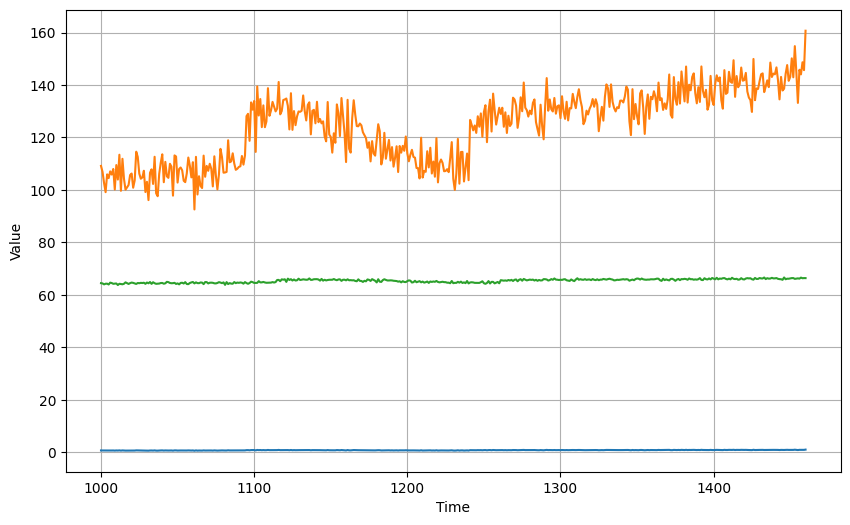

In [11]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return time * slope

def seasonality(time, period, amplitude=1, phase=0):
  """ """
  season_time =((time + period) % period) / period
  return amplitude * seasonal_pattern(season_time)

def seasonal_pattern(season_time):
  """Just an arbitrary pattern"""
  return np.where(
      season_time < 0.4,
      np.cos(season_time * 2 * np.pi),
      1/np.exp(3* season_time)
  )

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 +1, dtype="float32")
baesline = 10
series = trend(time, 0.1)
baseline  = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

min = np.min(series)
max = np.max(series)

series -= min
series /= max
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 20
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size +1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1)

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]


scaled_xvalid = x_valid*max
scaled_xvalid = scaled_xvalid+min
scaled_forecast = forecast*max
scaled_forecast = scaled_forecast+min

plot_series(time_valid, scaled_xvalid)
plot_series(time_valid, scaled_forecast)

print(max)

tf.keras.metrics.mean_absolute_error(scaled_xvalid, scaled_forecast).numpy()